# Movie Recommender - Project
Mat.-Nr: 6574933

Some more insights/backgrounds are in the project documentation.

First things first: some imports :D

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tabulate import tabulate

## Recommender System

### Import 100k-Movielens Data
The data is in csv files. To read and store them pandas got the method pd.read_csv()!

In [2]:
rating_data = pd.read_csv('Data/ml-100k/u.data', sep='\t', names=["userID", "movieID", "rating", "timestamp"])

user_data = pd.read_csv('Data/ml-100k/u.user', sep='|', names=["userID", "age", "gender",  "occupation", "zip code"])

movies = pd.read_csv('Data/ml-100k/u.item', sep='|', encoding='latin-1', names=["movieID", "title", "release date", "video release date", "IMDb URL", "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"])

### Data Analysis

So let`s start easy an look what the different dataframes look like :)

In [3]:
print("###"*20)
print("Number of users: {}\nNumber of movies: {}\nNumber of given ratings: {}".format(len(user_data), len(movies), len(rating_data)))

print("\n" + "###"*20 + "\n")

print("User Data:")
print(user_data.head())

print("\n" + "###"*20 + "\n")

print("Rating Data:")
print(rating_data.head())
print("###"*20)

############################################################
Number of users: 943
Number of movies: 1682
Number of given ratings: 100000

############################################################

User Data:
   userID  age gender  occupation zip code
0       1   24      M  technician    85711
1       2   53      F       other    94043
2       3   23      M      writer    32067
3       4   24      M  technician    43537
4       5   33      F       other    15213

############################################################

Rating Data:
   userID  movieID  rating  timestamp
0     196      242       3  881250949
1     186      302       3  891717742
2      22      377       1  878887116
3     244       51       2  880606923
4     166      346       1  886397596
############################################################


Let's analyse the users a bit more.

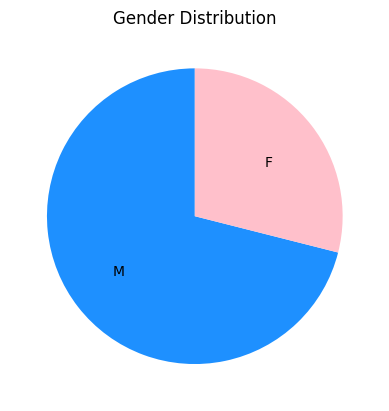

In [4]:
gender_counts = user_data['gender'].value_counts()
plt.pie(gender_counts, labels=gender_counts.index ,colors=['dodgerblue', 'pink'], labeldistance=0.6, startangle=90)
plt.title("Gender Distribution")
plt.show() 

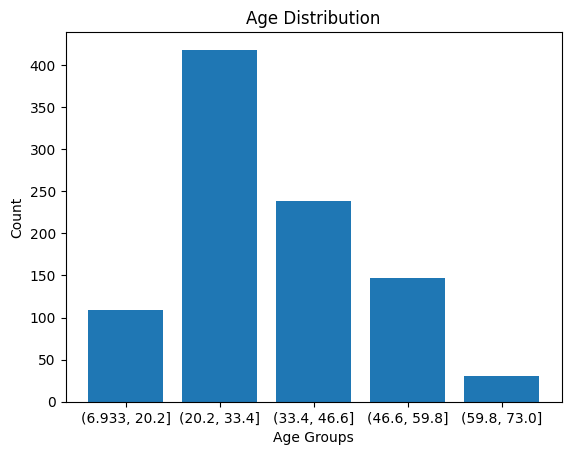

In [5]:
age_counts = user_data['age'].value_counts(bins=5).sort_index()
age_labels = [str(x) for x in age_counts.index]
plt.bar(age_labels, age_counts)
plt.xlabel("Age Groups")
plt.ylabel("Count")
plt.title("Age Distribution")
plt.show()

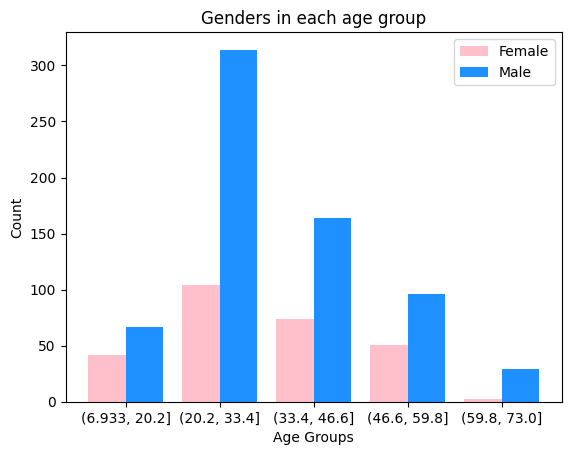

In [6]:
Male, Female = [], []

for x in age_counts.index:
    temp_user = user_data[user_data.age.between(x.left, x.right)]
    gender_counts = temp_user['gender'].value_counts()
    Male.append(gender_counts[0])
    Female.append(gender_counts[1])

X_axis = np.arange(len(age_labels))

plt.bar(X_axis - 0.2, Female, 0.4, label = 'Female', color = 'pink')
plt.bar(X_axis + 0.2, Male, 0.4, label = 'Male', color = 'dodgerblue')
  
plt.xticks(X_axis, age_labels)
plt.xlabel("Age Groups")
plt.ylabel("Count")
plt.title("Genders in each age group")
plt.legend()
plt.show()

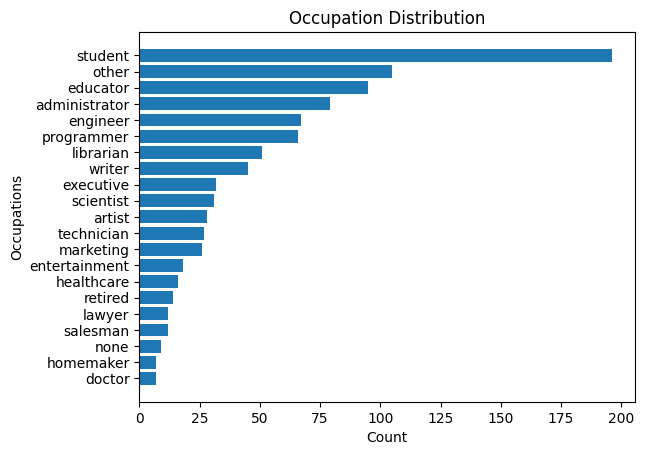

In [7]:
occupation_counts = user_data['occupation'].value_counts().sort_values(ascending=True)
plt.barh(occupation_counts.index, occupation_counts)
plt.xlabel("Count")
plt.ylabel("Occupations")
plt.title("Occupation Distribution")
plt.show()

Let's go on with some Movie Analysis...

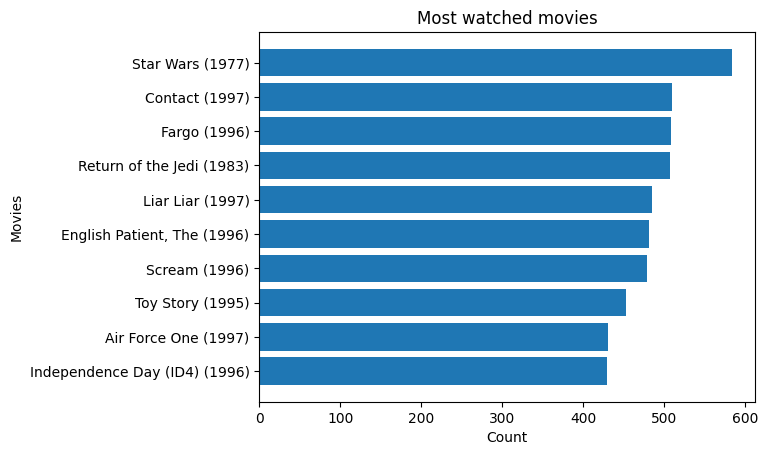

In [8]:
pop_df = rating_data.groupby('movieID').count()['rating'].reset_index(name='count').sort_values('count', ascending=False)
movies = pd.merge(movies, pop_df, on="movieID")
most_watched_movies = movies.nlargest(10,'count').sort_values(by='count')
plt.barh(most_watched_movies["title"], most_watched_movies["count"])
plt.xlabel("Count")
plt.ylabel("Movies")
plt.title("Most watched movies")
plt.show()

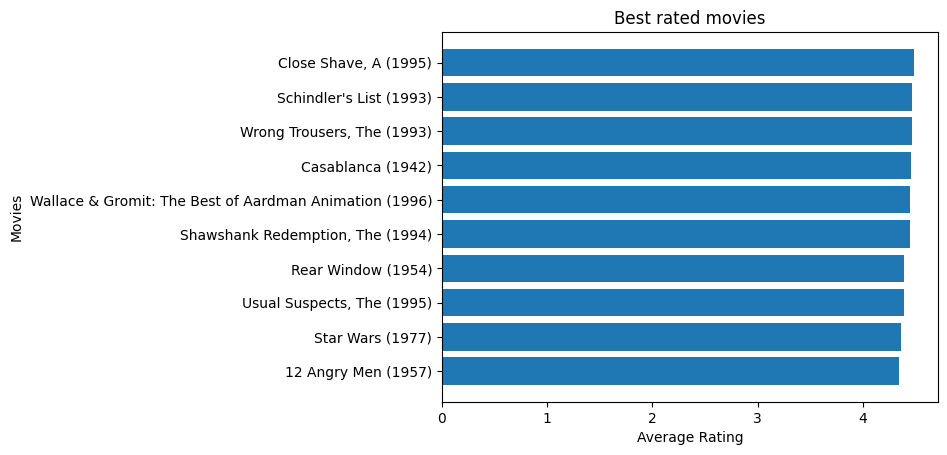

In [9]:
rating_df_agg = rating_data.groupby('movieID').agg(avg_rating=('rating', 'mean')).reset_index()
rating_df_agg['avg_rating'] = np.round(rating_df_agg['avg_rating'], 2)

rating_df_agg = pd.merge(rating_df_agg, movies, on='movieID', how='inner')
rating_df_agg = rating_df_agg[rating_df_agg['count']>10]
most_popular_movies = rating_df_agg.nlargest(10,'avg_rating').sort_values(by='avg_rating')
plt.barh(most_popular_movies["title"], most_popular_movies["avg_rating"])
plt.xlabel("Average Rating")
plt.ylabel("Movies")
plt.title("Best rated movies")
plt.show()

Note: One movie can have multiple genres!


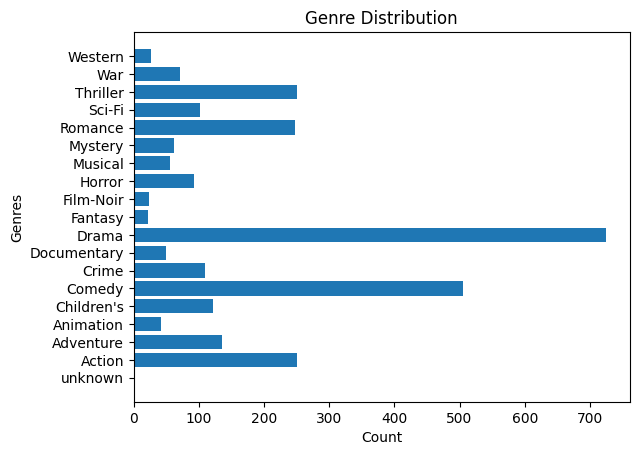

In [10]:
# Genres
movies_genre_name = np.array(pd.read_csv('Data/ml-100k/u.genre', sep='|', header=None, engine='python', encoding='latin-1').loc[:, 0])
movies_genre = {}
for x in movies_genre_name:
    movies_genre [x] = movies[x].value_counts()[1]
print("Note: One movie can have multiple genres!")
plt.barh(movies_genre_name, movies_genre.values())
plt.xlabel("Count")
plt.ylabel("Genres")
plt.title("Genre Distribution")
plt.show()

And last but most important: Let's have a deeper look into the Rating data (the real data)! This is the data our model will learn and predict.

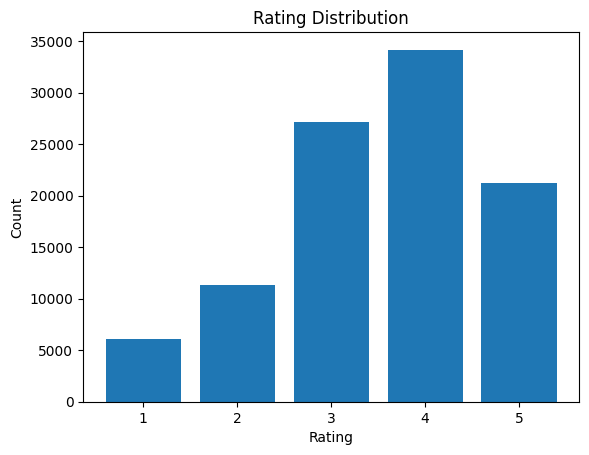

In [11]:
rating_counts = rating_data["rating"].value_counts().sort_index()
plt.bar(rating_counts.index, rating_counts)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Rating Distribution")
plt.show()

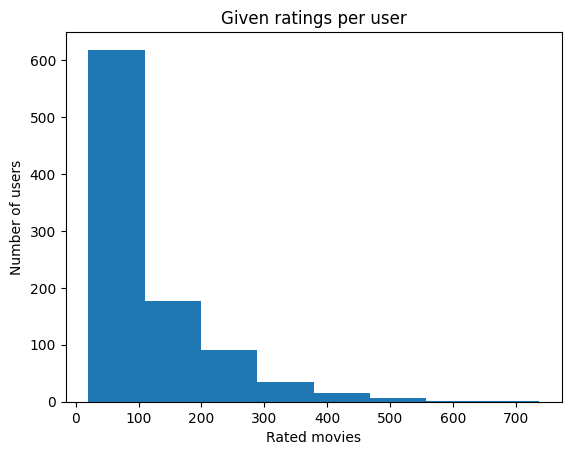

In [12]:
given_ratings_per_user = rating_data["userID"].value_counts()
plt.hist(given_ratings_per_user, 8)
plt.xlabel("Rated movies")
plt.ylabel("Number of users")
plt.title("Given ratings per user")
plt.show()

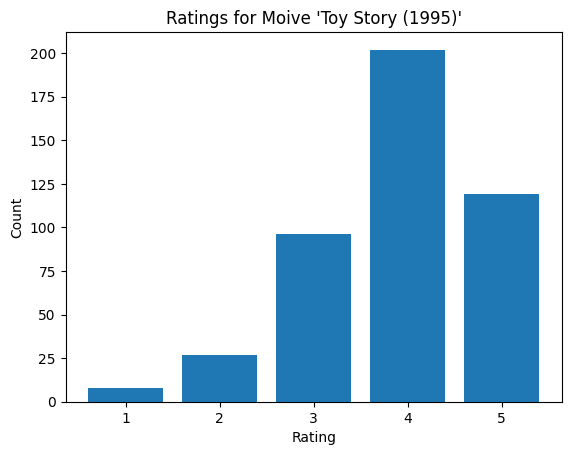

In [13]:
#value counts of movie Toy story
rating_toy_story = rating_data.loc[rating_data["movieID"]==int(movies[movies["title"]=='Toy Story (1995)']['movieID'])]['rating'].value_counts()
plt.bar(rating_toy_story.index, rating_toy_story)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Ratings for Moive 'Toy Story (1995)'")
plt.show()

Let's again go back to the genders and have a look at the mean rating for some movies of different genres!

In [14]:
full_df = pd.merge(rating_data, user_data, how='left', on = 'userID')
full_df = pd.merge(full_df, movies, how='left', on = 'movieID')

def print_gender_movie_rating(genre_movie_list, genre: str):
    print('Genre: {}'.format(genre))
    table_data = []
    for i_movie in genre_movie_list:
        temp_df = full_df[full_df['title']==i_movie]
        table_data.append([i_movie, temp_df[temp_df['gender']=='M']['rating'].mean(),  temp_df[temp_df['gender']=='F']['rating'].mean()])
    temp_df = full_df[full_df[genre]==1]
    table_data.append(["Overall", temp_df[temp_df['gender']=='M']['rating'].mean(),  temp_df[temp_df['gender']=='F']['rating'].mean()])
    print(tabulate(table_data, headers=['Movie Titles', 'Male Mean Rating', "Female Mean Rating"], tablefmt='orgtbl'))
    print('---'*8 + "\n")

In [15]:
# Drama
drama_movies = ['Taxi Driver (1976)', 'Godfather, The (1972)', "Schindler's List (1993)"]
print_gender_movie_rating(drama_movies, 'Drama')

# Romance
romance_movies = ["Titanic (1997)", "Everyone Says I Love You (1996)", "Wedding Singer, The (1998)"]
print_gender_movie_rating(romance_movies, 'Romance')

# Horror
horror_movies = ["Scream (1996)", "Stephen King's The Langoliers (1995)", "Halloween: The Curse of Michael Myers (1995)"]
print_gender_movie_rating(horror_movies, 'Horror')

Genre: Drama
| Movie Titles            |   Male Mean Rating |   Female Mean Rating |
|-------------------------+--------------------+----------------------|
| Taxi Driver (1976)      |            4.11111 |              4.17241 |
| Godfather, The (1972)   |            4.33442 |              4.13333 |
| Schindler's List (1993) |            4.40639 |              4.63291 |
| Overall                 |            3.69696 |              3.66225 |
------------------------

Genre: Romance
| Movie Titles                    |   Male Mean Rating |   Female Mean Rating |
|---------------------------------+--------------------+----------------------|
| Titanic (1997)                  |            4.23171 |              4.27885 |
| Everyone Says I Love You (1996) |            3.27928 |              3.26316 |
| Wedding Singer, The (1998)      |            3.45455 |              3.58824 |
| Overall                         |            3.60707 |              3.65568 |
------------------------

Genre: H

### Data Preprocessing

In [16]:
# Drop user data I will not use
user_data = user_data.drop(columns=['zip code'])

# Gender: Convert 'M' and 'F' to 0 and 1
user_data['gender'] = np.where(np.matrix(user_data['gender']) == 'M', 0, 1)[0]

# Occupation: Convert strings to int --> Network can handle it
occupation_list = {"none": 0,  "other": 1, "student": 2, "homemaker": 3, "artist": 4, "writer": 5, "entertainment": 6, "administrator": 7, "educator": 8, "librarian": 9,
                   "lawyer": 10, "healthcare": 11, "doctor": 12, "scientist": 13, "engineer": 14, "technician": 15, "programmer": 16, "marketing": 17, "salesman": 18, 
                   "executive": 19, "retired": 20
                }
user_data['occupation'] = user_data['occupation'].map(occupation_list)

# Drop some movie data I will not use
movie_data = movies.drop(columns=["title", "release date", "IMDb URL", "video release date", "count"])

In [17]:
# Read in predefined training and test set from the data
training = pd.read_csv('Data/ml-100k/u1.base', sep='\t', names=["userID", "movieID", "rating", "timestamp"])
test = pd.read_csv('Data/ml-100k/u1.test', sep='\t', names=["userID", "movieID", "rating", "timestamp"])

In [18]:
# Age: Normalize age to values between 0-1
min_age = min(user_data["age"])
max_age = max(user_data["age"])
user_data['age'] = user_data["age"].apply(lambda x: (x - min_age) / (max_age - min_age))


# Rating: Normalize rating to values between 0-1
# For training and test set
min_rating = min(rating_data["rating"])
max_rating = max(rating_data["rating"])

training["rating"] = training["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))
test["rating"] = test["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))


# Timestamp: Normalize timestamps to values between 0-1
# For training and test set
min_time = min(rating_data["timestamp"])
max_time = max(rating_data["timestamp"])

training["timestamp"] = training["timestamp"].apply(lambda x: (x - min_time) / (max_time - min_time))
test["timestamp"] = test["timestamp"].apply(lambda x: (x - min_time) / (max_time - min_time))

In [19]:
# Bring all the data together
training = pd.merge(training, user_data, how='left', on='userID')
test = pd.merge(test, user_data, how='left', on='userID')

training = pd.merge(training, movie_data, how='left', on='movieID')
test = pd.merge(test, movie_data, how='left', on='movieID')

In [20]:
# Shift UserID and MovieID: Values starting from 0 instead of 1
training["userID"] = training["userID"].apply(lambda x: x-1)
training["movieID"] = training["movieID"].apply(lambda x: x-1)

test["userID"] = test["userID"].apply(lambda x: x-1)
test["movieID"] = test["movieID"].apply(lambda x: x-1)

rating_data["userID"] = rating_data["userID"].apply(lambda x: x-1)
rating_data["movieID"] = rating_data["movieID"].apply(lambda x: x-1)

movie_data["movieID"] = movie_data["movieID"].apply(lambda x: x-1)

In [21]:
# Different Training and test sets for different models with different amount of information

training_base = training[['userID', "movieID", "rating"]]
test_base = test[['userID', "movieID", "rating"]]


extended_columns = ['userID', 'movieID', 'rating', 'age', 'gender', 'unknown',
       'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

training_extended = training[extended_columns]
test_extended = test[extended_columns]

training_full = training
test_full = test

### Training and Validation Set

I thoght of different ways to split the data.

1. Split with user distribution

    The users are split that there is a similar age and gender distribution in the training and test set. 

2. Split by movies/ratings from same user

    Traings and test set both contain ratings from the same users. But in test set the are ratings not seen during training. It's the more common way to split data for recommenders. This method is also used by the pre-build "u*.base" and "u*.test" files. They contain at least one rating from each user.

First I don't want to focus to much on data spliting because I want to get a model to run. That's why I startet with using the pre-builded sets.




In [22]:
def convert_trining_test_set(training, test):
    x_training = training.drop(columns=["rating"])
    x_training = x_training.to_numpy(dtype=np.float64)
    y_training = training["rating"].to_numpy(dtype=np.float64)

    x_test = test.drop(columns=["rating"])
    x_test = x_test.to_numpy(dtype=np.float64)
    y_test = test["rating"].to_numpy(dtype=np.float64)

    return x_training, y_training, x_test, y_test

In [23]:
x_training_base, y_training_base, x_test_base, y_test_base = convert_trining_test_set(training_base, test_base)
training_compare, test_compare = training_extended.copy(), test_extended.copy()
training_compare["userID"], test_compare["userID"] = 0, 0
x_training_compare, y_training_compare, x_test_compare, y_test_compare = convert_trining_test_set(training_compare, test_compare)
x_training_extended, y_training_extended, x_test_extended, y_test_extended = convert_trining_test_set(training_extended, test_extended)
x_training_full, y_training_full, x_test_full, y_test_full = convert_trining_test_set(training_full, test_full)

### Build Model
Code from "Cold start": https://keras.io/examples/structured_data/collaborative_filtering_movielens/#collaborative-filtering-for-movie-recommendations

It uses collaborative filtering for recommendations. The figure shows how that works.

<center><img src="graphics/2Dmatrix.png" width="700"><br></center>
<center> Fig. 1: Collaborative Filtering. Image from https://developers.google.com/machine-learning/recommendation/collaborative/basics </center>

In [24]:
EMBEDDING_SIZE = 50


class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="zeros",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="zeros",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


In [25]:
model_base = RecommenderNet(len(user_data), len(movie_data), EMBEDDING_SIZE)
model_extended = RecommenderNet(len(user_data), len(movie_data), EMBEDDING_SIZE)
model_full = RecommenderNet(len(user_data), len(movie_data), EMBEDDING_SIZE)


model_base.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_extended.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_full.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

### Fit Model

Callbacks for example early stopping prevent overfitting. It stops when theres no improvement in validation loss. Before early stopping the learning rate gets reduced so maybe the performance can achive a better result.

In [26]:
es = tf.keras.callbacks.EarlyStopping(
                    monitor='val_loss',
                    min_delta=0,
                    patience=3,
                    mode='auto'
                    )

reduce_lrs = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=1)

In [27]:
history_base = model_base.fit(
    x=x_training_base,
    y=y_training_base,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks = [es, reduce_lrs],
    validation_data=(x_test_base, y_test_base),
)

Epoch 1/10
5000/5000 [==============================] - 12s 2ms/step - loss: 0.6499 - accuracy: 0.2252 - val_loss: 0.6224 - val_accuracy: 0.2528 - lr: 0.0010
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6161 - accuracy: 0.2347 - val_loss: 0.6072 - val_accuracy: 0.2566 - lr: 0.0010
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6077 - accuracy: 0.2375 - val_loss: 0.6025 - val_accuracy: 0.2587 - lr: 0.0010
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6044 - accuracy: 0.2391 - val_loss: 0.6005 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6027 - accuracy: 0.2399 - val_loss: 0.5995 - val_accuracy: 0.2607 - lr: 0.0010
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6017 - accuracy: 0.2404 - val_loss: 0.5989 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 7/10
5000/5000 [==============================

In [28]:
history_extended = model_extended.fit(
    x=x_training_extended,
    y=y_training_extended,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks = [es, reduce_lrs],
    validation_data=(x_test_extended, y_test_extended),
)

Epoch 1/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.6501 - accuracy: 0.2255 - val_loss: 0.6222 - val_accuracy: 0.2531 - lr: 0.0010
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6161 - accuracy: 0.2350 - val_loss: 0.6070 - val_accuracy: 0.2571 - lr: 0.0010
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6077 - accuracy: 0.2379 - val_loss: 0.6024 - val_accuracy: 0.2591 - lr: 0.0010
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6044 - accuracy: 0.2391 - val_loss: 0.6004 - val_accuracy: 0.2596 - lr: 0.0010
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6027 - accuracy: 0.2401 - val_loss: 0.5994 - val_accuracy: 0.2601 - lr: 0.0010
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6017 - accuracy: 0.2406 - val_loss: 0.5988 - val_accuracy: 0.2606 - lr: 0.0010
Epoch 7/10
5000/5000 [==============================

In [29]:
history_full = model_full.fit(
    x=x_training_full,
    y=y_training_full,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks = [es, reduce_lrs],
    validation_data=(x_test_full, y_test_full),
)

Epoch 1/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.6501 - accuracy: 0.2247 - val_loss: 0.6224 - val_accuracy: 0.2532 - lr: 0.0010
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6161 - accuracy: 0.2349 - val_loss: 0.6071 - val_accuracy: 0.2569 - lr: 0.0010
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6077 - accuracy: 0.2378 - val_loss: 0.6024 - val_accuracy: 0.2591 - lr: 0.0010
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6044 - accuracy: 0.2392 - val_loss: 0.6005 - val_accuracy: 0.2598 - lr: 0.0010
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6027 - accuracy: 0.2399 - val_loss: 0.5994 - val_accuracy: 0.2605 - lr: 0.0010
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6017 - accuracy: 0.2406 - val_loss: 0.5989 - val_accuracy: 0.2604 - lr: 0.0010
Epoch 7/10
5000/5000 [==============================

### Evaluation

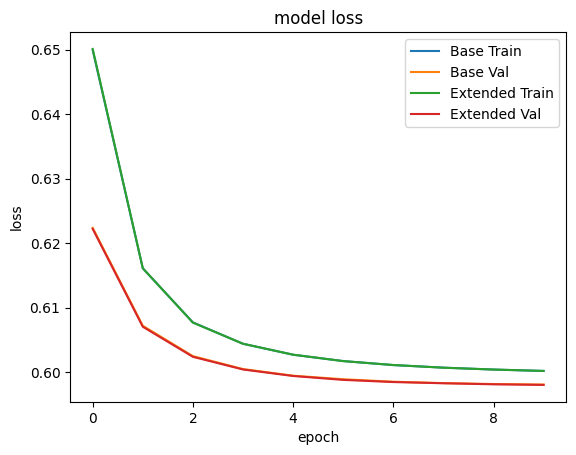

In [30]:
plt.plot(history_base.history["loss"], label="Base Train")
plt.plot(history_base.history["val_loss"], label="Base Val")
plt.plot(history_extended.history["loss"], label="Extended Train")
plt.plot(history_extended.history["val_loss"], label="Extended Val")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper right")
plt.show()

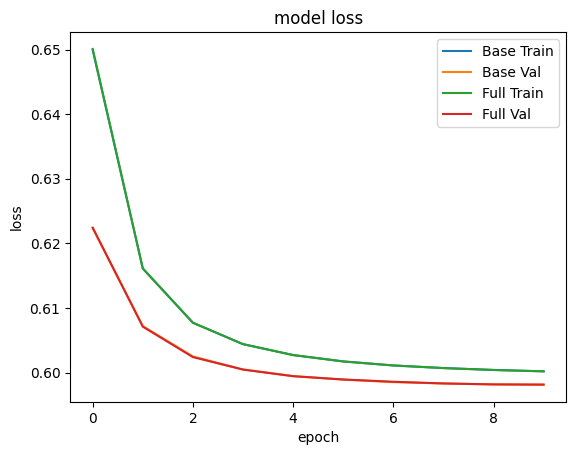

In [31]:
plt.plot(history_base.history["loss"], label="Base Train")
plt.plot(history_base.history["val_loss"], label="Base Val")
plt.plot(history_full.history["loss"], label="Full Train")
plt.plot(history_full.history["val_loss"], label="Full Val")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper right")
plt.show()

As we can see: All models got the same loss and val_loss. There are no real differences between them in performance. A bit strange isn't it? That'S not what I expected when I started with this task. But more about that in my docu. ;)

#### Make Recommendations for users

In [32]:
def get_movie_recommendations(model, userID):
    movies_watched_by_user = rating_data[rating_data.userID == userID]
    movies_not_watched = movie_data[
        ~movie_data["movieID"].isin(movies_watched_by_user.movieID.values)
    ]["movieID"]
    movies_not_watched = [[x] for x in movies_not_watched]
    user_array = [[userID]] * len(movies_not_watched)
    user_movie_array = np.hstack(
        (user_array, movies_not_watched)
    )
    predicted_ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = predicted_ratings.argsort()[-10:][::-1]
    recommended_movies = movies[movies["movieID"].isin(top_ratings_indices)]["title"].to_numpy()
    return recommended_movies

In [33]:
# Let us get a user and see the top recommendations.
userID = 942
recommended_movies_base = get_movie_recommendations(model_base, userID)
recommended_movies_extended = get_movie_recommendations(model_extended, userID)
recommended_movies_full = get_movie_recommendations(model_full, userID)


48/48 [==============================] - 0s 967us/step


In [34]:
print("Showing recommendations for user: {}".format(userID))
print("====" * 8)
print("Movies with high ratings from user")
print("----" * 8)
movies_watched_by_user = rating_data[rating_data.userID == userID]
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieID.values
)
movie_df_rows = movies[movies["movieID"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
table_data = []
for i in range(10):
    table_data.append([recommended_movies_base[i], recommended_movies_extended[i],  recommended_movies_full[i]]) 
print(tabulate(table_data, headers=['Base Model', 'Extended Model', "Full Model"], tablefmt='orgtbl'))


Showing recommendations for user: 942
Movies with high ratings from user
--------------------------------
Professional, The (1994)
Alien (1979)
Right Stuff, The (1983)
Terminator, The (1984)
Streetcar Named Desire, A (1951)
--------------------------------
Top 10 movie recommendations
--------------------------------
| Base Model                                  | Extended Model                              | Full Model                                  |
|---------------------------------------------+---------------------------------------------+---------------------------------------------|
| Carlito's Way (1993)                        | Carlito's Way (1993)                        | Carlito's Way (1993)                        |
| Independence Day (ID4) (1996)               | Independence Day (ID4) (1996)               | Independence Day (ID4) (1996)               |
| Godfather, The (1972)                       | Godfather, The (1972)                       | Godfather, The (1972)      

The movie recommendations are quite simular / completly the same for this user. Maybe the order is a bit different but the movies are the same. As all models got the same val_loss this is the expected result.

##### Predict and compare seen movies

In [35]:
def predict_seen_movies(models: list, userID, n_movies = 5):
    df = rating_data[rating_data["userID"]==(userID+1)].head(n_movies)
    movieIDs = df['movieID'].to_numpy()
    movie_titles = []
    movie_df_rows = movies[movies["movieID"].isin(movieIDs)]
    for row in movie_df_rows.itertuples():
        movie_titles.append(row.title)
    user_ratings = df['rating'].to_numpy()
    model_predictions = []
    user_movie_array = np.hstack(
        ([[userID]] * n_movies, [[x] for x in movieIDs])
    )
    for model in models:
        model_predictions.append(model.predict(user_movie_array).flatten()*5)

    
    return movie_titles, user_ratings, model_predictions

In [36]:
userID = 457
n_movies = 5
movie_titles, user_ratings, model_predictions = predict_seen_movies([model_base, model_extended, model_full], userID, n_movies)
print("Showing Predicitions for user: {}".format(userID))
print("====" * 8)
table_data = []
for i in range(n_movies):
    table_data.append([movie_titles[i], user_ratings[i],  model_predictions[0][i], model_predictions[1][i], model_predictions[2][i]]) 
print(tabulate(table_data, headers=['Movie Title', 'User Rating', 'Base Model', "Extended Model", "Full Model"], tablefmt='orgtbl'))

1/1 [==============================] - 0s 99ms/step
Showing Predicitions for user: 457
| Movie Title                                                                     |   User Rating |   Base Model |   Extended Model |   Full Model |
|---------------------------------------------------------------------------------+---------------+--------------+------------------+--------------|
| Right Stuff, The (1983)                                                         |             3 |      2.10334 |          2.14838 |      2.10441 |
| Field of Dreams (1989)                                                          |             3 |      2.83068 |          2.82773 |      2.77588 |
| Fan, The (1996)                                                                 |             3 |      3.79929 |          3.80633 |      3.78474 |
| Funeral, The (1996)                                                             |             1 |      2.53333 |          2.52794 |      2.4587  |
| Don't Be a Menace

Also the predictions for movies the user has already seen are all quite simular.

##### Compare Model
Let's look how a model performes with just the demographic data without the userID. How much information is there? Or is evene more information in just the userID as a number that represents a individuum/person. 

In [37]:
model_compare = RecommenderNet(1, len(movie_data), EMBEDDING_SIZE)

model_compare.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history_compare = model_compare.fit(
    x=x_training_compare,
    y=y_training_compare,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks = [es, reduce_lrs],
    validation_data=(x_test_compare, y_test_compare),
)

Epoch 1/10
5000/5000 [==============================] - 11s 2ms/step - loss: 0.6487 - accuracy: 0.2086 - val_loss: 0.6362 - val_accuracy: 0.2228 - lr: 0.0010
Epoch 2/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6344 - accuracy: 0.2124 - val_loss: 0.6284 - val_accuracy: 0.2305 - lr: 0.0010
Epoch 3/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6296 - accuracy: 0.2199 - val_loss: 0.6251 - val_accuracy: 0.2384 - lr: 0.0010
Epoch 4/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6274 - accuracy: 0.2238 - val_loss: 0.6233 - val_accuracy: 0.2408 - lr: 0.0010
Epoch 5/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6263 - accuracy: 0.2259 - val_loss: 0.6224 - val_accuracy: 0.2435 - lr: 0.0010
Epoch 6/10
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6256 - accuracy: 0.2272 - val_loss: 0.6218 - val_accuracy: 0.2449 - lr: 0.0010
Epoch 7/10
5000/5000 [==============================

The validation loss is a higher then in the model with just the user ID. That means theres more information in the user ID then in the rest of the data. This explains why my model with more data is only slightly better.

### Different Ideas for Training / Test Data
In the models above I used the prebuild Training and Test Set splits. Now I want to try out to split the data on my own and compare the results. Also I want to use Cross Validation with the prebuild sets.
#### Cross Validation
Cross Validation is common way to use the data for Training and Validation when theres no real Training and Validation Test split. The figure below shows the concept of Cross Validation.
<center><img src="graphics/cross_val.jpg" width="700"><br></center>
<center> Fig. 2: Concept of Cross Validation. Image from https://de.mathworks.com/discovery/cross-validation.html </center>


In [38]:
# Read and preprocess the data sets
training_cross = []
test_cross = []
for i in range(1, 6):
    training = pd.read_csv('Data/ml-100k/u' + str(i) + '.base', sep='\t', names=["userID", "movieID", "rating", "timestamp"])
    test = pd.read_csv('Data/ml-100k/u' + str(i) + '.test', sep='\t', names=["userID", "movieID", "rating", "timestamp"])

    training["rating"] = training["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))
    test["rating"] = test["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

    training["timestamp"] = training["timestamp"].apply(lambda x: (x - min_time) / (max_time - min_time))
    test["timestamp"] = test["timestamp"].apply(lambda x: (x - min_time) / (max_time - min_time))

    training = pd.merge(training, user_data, how='left', on='userID')
    test = pd.merge(test, user_data, how='left', on='userID')

    training = pd.merge(training, movie_data, how='left', on='movieID')
    test = pd.merge(test, movie_data, how='left', on='movieID')

    training["userID"] = training["userID"].apply(lambda x: x-1)
    training["movieID"] = training["movieID"].apply(lambda x: x-1)

    test["userID"] = test["userID"].apply(lambda x: x-1)
    test["movieID"] = test["movieID"].apply(lambda x: x-1)

    training = training[extended_columns]
    test = test[extended_columns]  

    training_cross.append(training)
    test_cross.append(test)

In [39]:
# Define Model
model_cross = RecommenderNet(len(user_data), len(movie_data), EMBEDDING_SIZE)

model_cross.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [40]:
# Train Model using Cross Validation
def cross_evaluate_model(training, test):
	scores, histories = list(), list()
	n_folds = 5 
	
	# enumerate splits
	for i_fold in range(n_folds):
		print("="*80)
		print("Fold-{}".format(i_fold + 1))
		print("-"*80)
		print("Training & Validation")
		
		# set train and test
		x_training = training[i_fold].drop(columns=["rating"])
		x_training = x_training.to_numpy(dtype=np.float64)
		y_training = training[i_fold]["rating"].to_numpy(dtype=np.float64)

		x_test = test[i_fold].drop(columns=["rating"])
		x_test = x_test.to_numpy(dtype=np.float64)
		y_test = test[i_fold]["rating"].to_numpy(dtype=np.float64)

		# fit model
		history = model_cross.fit(x_training, y_training, epochs=5, batch_size=16, validation_data=(x_test, y_test), callbacks=[es])
		# evaluate model
		print("-"*80)
		print("Testing/evaluation")
		acc = model_cross.evaluate(x_test, y_test)
		# stores scores
		scores.append(acc)
		histories.append(history)
	return scores, histories

scores, histories = cross_evaluate_model(training_cross, test_cross)

Fold-1
--------------------------------------------------------------------------------
Training & Validation
Epoch 1/5
5000/5000 [==============================] - 11s 2ms/step - loss: 0.6503 - accuracy: 0.2243 - val_loss: 0.6225 - val_accuracy: 0.2522
Epoch 2/5
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6163 - accuracy: 0.2352 - val_loss: 0.6072 - val_accuracy: 0.2569
Epoch 3/5
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6078 - accuracy: 0.2377 - val_loss: 0.6025 - val_accuracy: 0.2588
Epoch 4/5
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6044 - accuracy: 0.2392 - val_loss: 0.6005 - val_accuracy: 0.2597
Epoch 5/5
5000/5000 [==============================] - 10s 2ms/step - loss: 0.6027 - accuracy: 0.2402 - val_loss: 0.5994 - val_accuracy: 0.2601
--------------------------------------------------------------------------------
Testing/evaluation
625/625 [==============================] - 1s 1ms/step - loss: 0.5994 

##### Evaluation of Cross Validation

In [41]:
userID = 852
recommended_movies_extended = get_movie_recommendations(model_extended, userID)
recommended_movies_cross = get_movie_recommendations(model_cross, userID)
print("Showing recommendations for user: {}".format(userID))
print("====" * 8)
print("Movies with high ratings from user")
print("----" * 8)
movies_watched_by_user = rating_data[rating_data.userID == userID]
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieID.values
)
movie_df_rows = movies[movies["movieID"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
table_data = []
for i in range(10):
    table_data.append([recommended_movies_extended[i], recommended_movies_cross[i]]) 
print(tabulate(table_data, headers=['Extended Model', "Cross Model"], tablefmt='orgtbl'))

52/52 [==============================] - 0s 941us/step
Showing recommendations for user: 852
Movies with high ratings from user
--------------------------------
Hoodlum (1997)
Ulee's Gold (1997)
Wishmaster (1997)
Peacemaker, The (1997)
Mrs. Dalloway (1997)
--------------------------------
Top 10 movie recommendations
--------------------------------
| Extended Model                                             | Cross Model                                                |
|------------------------------------------------------------+------------------------------------------------------------|
| Seven (Se7en) (1995)                                       | Seven (Se7en) (1995)                                       |
| I.Q. (1994)                                                | Santa Clause, The (1994)                                   |
| Santa Clause, The (1994)                                   | Horseman on the Roof, The (Hussard sur le toit, Le) (1995) |
| Horseman on the Roof, The 

As we can see, this time there are completly different predictions. So which one is better? According to val_loss the extended model performeces better but let's have a look at some examples.

In [42]:
userID = 576
n_movies = 5
movie_titles, user_ratings, model_predictions = predict_seen_movies([model_extended, model_cross], userID, n_movies)
print("Showing Predicitions for user: {}".format(userID))
print("====" * 8)
table_data = []
for i in range(n_movies):
    table_data.append([movie_titles[i], user_ratings[i],  model_predictions[0][i], model_predictions[1][i]]) 
print(tabulate(table_data, headers=['Movie Title', 'User Rating', "Extended Model", "Cross Model"], tablefmt='orgtbl'))

1/1 [==============================] - 0s 97ms/step
Showing Predicitions for user: 576
| Movie Title                                        |   User Rating |   Extended Model |   Cross Model |
|----------------------------------------------------+---------------+------------------+---------------|
| Donnie Brasco (1997)                               |             3 |          3.10913 |       3.10525 |
| Murder at 1600 (1997)                              |             3 |          3.41202 |       3.4583  |
| Wedding Singer, The (1998)                         |             3 |          2.90626 |       2.84619 |
| Tales From the Crypt Presents: Demon Knight (1995) |             3 |          3.35085 |       3.52643 |
| Foxfire (1996)                                     |             1 |          2.71468 |       2.94328 |


Again, the values are close together. In generall the model without cross validation is a little closer to the User rating.

#### Own Data Split?
Now it's time to compare my own data split to the prebuild one. But first I have to split the data. As always in this project I will use the whole data for Training and Validation and don't use a extra Test Set.
The MovieLens data only contains data from users that minimum rated 20 movies. To guarantee there is a ranking from every user in the validation set I take the last 5 rated movies and put them into the validation set. This concept is often used for Recommender Systems. The figure below shows that for the last reviewed movie.

<center><img src="graphics/data_split.png" width="700"><br></center>
<center> Fig. 3: Data Spliting. Image from https://www.kaggle.com/code/jamesloy/deep-learning-based-recommender-systems/notebook </center>

Now I want an 80:20 split of the data. So I fill the validation set with random ratings. But I pay attention to the gender distrubtion, so I fill with more Males then Females. Same could be done with age groups and their distribution. For now I just used genders.

In [43]:
rating_data = pd.read_csv('Data/ml-100k/u.data', sep='\t', names=["userID", "movieID", "rating", "timestamp"])

df = pd.merge(rating_data, user_data, how='left', on='userID')

df = pd.merge(df, movie_data, how='left', on='movieID')

df["rating"] = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating))
df["userID"] = df["userID"].apply(lambda x: x-1)
df["movieID"] = df["movieID"].apply(lambda x: x-1)

df['rank_latest'] = df.groupby(['userID'])['timestamp'].rank(method='first', ascending=False)

train_ratings = df[df['rank_latest'] >5]
test_ratings = df[df['rank_latest'] <=5]

print("Train : Test =", len(train_ratings), ":", len(test_ratings))

Train : Test = 95285 : 4715


In [44]:
# Split genders
train_ratings_male = train_ratings[train_ratings['gender'] == 1]
train_ratings_female = train_ratings[train_ratings['gender'] == 0]

# Fill test set to 80:20 split
train_male, test_male = train_test_split(train_ratings_male, test_size=0.259*len(train_ratings_male)/len(train_ratings))
train_female, test_female = train_test_split(train_ratings_female, test_size=0.259*len(train_ratings_female)/len(train_ratings))

train_ratings = pd.concat([train_male, train_female], ignore_index=True)
test_ratings = pd.concat([test_ratings, test_male, test_female], ignore_index=True)

print("Train : Test =", len(train_ratings), ":", len(test_ratings))

# drop columns that we no longer need
train_ratings = train_ratings[extended_columns]
test_ratings = test_ratings[extended_columns]

x_training, y_training, x_test, y_test = convert_trining_test_set(train_ratings, test_ratings)

Train : Test = 80002 : 19998


In [45]:
# Define and Train model
model_own_data = RecommenderNet(len(user_data), len(movie_data), EMBEDDING_SIZE)

model_own_data.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

history_own_data = model_own_data.fit(
    x=x_training,
    y=y_training,
    batch_size=16,
    epochs=10,
    verbose=1,
    callbacks = [es, reduce_lrs],
    validation_data=(x_test, y_test),
)

Epoch 1/10
5001/5001 [==============================] - 12s 2ms/step - loss: 0.6490 - accuracy: 0.2292 - val_loss: 0.6276 - val_accuracy: 0.2328 - lr: 0.0010
Epoch 2/10
5001/5001 [==============================] - 11s 2ms/step - loss: 0.6142 - accuracy: 0.2397 - val_loss: 0.6142 - val_accuracy: 0.2367 - lr: 0.0010
Epoch 3/10
5001/5001 [==============================] - 11s 2ms/step - loss: 0.6057 - accuracy: 0.2427 - val_loss: 0.6100 - val_accuracy: 0.2383 - lr: 0.0010
Epoch 4/10
5001/5001 [==============================] - 11s 2ms/step - loss: 0.6024 - accuracy: 0.2440 - val_loss: 0.6082 - val_accuracy: 0.2391 - lr: 0.0010
Epoch 5/10
5001/5001 [==============================] - 11s 2ms/step - loss: 0.6007 - accuracy: 0.2452 - val_loss: 0.6073 - val_accuracy: 0.2397 - lr: 0.0010
Epoch 6/10
5001/5001 [==============================] - 11s 2ms/step - loss: 0.5997 - accuracy: 0.2455 - val_loss: 0.6068 - val_accuracy: 0.2400 - lr: 0.0010
Epoch 7/10
5001/5001 [==============================

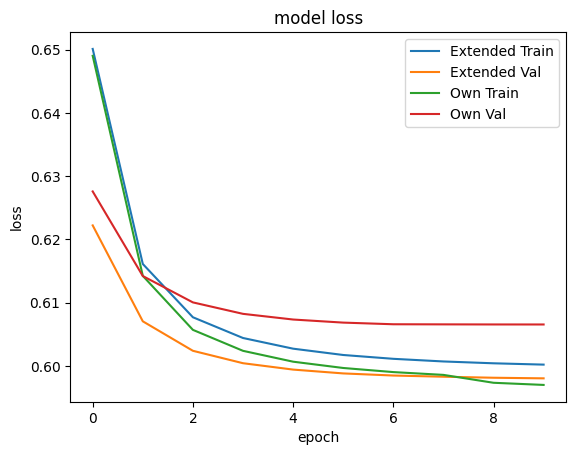

In [46]:
plt.plot(history_extended.history["loss"], label="Extended Train")
plt.plot(history_extended.history["val_loss"], label="Extended Val")
plt.plot(history_own_data.history["loss"], label="Own Train")
plt.plot(history_own_data.history["val_loss"], label="Own Val")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(loc="upper right")
plt.show()

The val_loss of the own data split looks like overfitting. Maybe the learning rate could be a bit smaller for a better result. In general the model with the prebuild data split performances much better.

##### Evaluation

In [47]:
userID = 27
recommended_movies_extended = get_movie_recommendations(model_extended, userID)
recommended_movies_own = get_movie_recommendations(model_own_data, userID)
print("Showing recommendations for user: {}".format(userID))
print("====" * 8)
print("Movies with high ratings from user")
print("----" * 8)
movies_watched_by_user = rating_data[rating_data.userID == userID]
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieID.values
)
movie_df_rows = movies[movies["movieID"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title)

print("----" * 8)
print("Top 10 movie recommendations")
print("----" * 8)
table_data = []
for i in range(10):
    table_data.append([recommended_movies_extended[i], recommended_movies_own[i]]) 
print(tabulate(table_data, headers=['Reference: Prebuild', "Own Data Split"], tablefmt='orgtbl'))

52/52 [==============================] - 0s 941us/step
Showing recommendations for user: 27
Movies with high ratings from user
--------------------------------
Fargo (1996)
Independence Day (ID4) (1996)
Frighteners, The (1996)
Face/Off (1997)
Trees Lounge (1996)
--------------------------------
Top 10 movie recommendations
--------------------------------
| Reference: Prebuild         | Own Data Split              |
|-----------------------------+-----------------------------|
| Richard III (1995)          | Richard III (1995)          |
| Hoop Dreams (1994)          | Hoop Dreams (1994)          |
| Three Colors: White (1994)  | Three Colors: White (1994)  |
| Operation Dumbo Drop (1995) | Operation Dumbo Drop (1995) |
| Top Gun (1986)              | Top Gun (1986)              |
| Ulee's Gold (1997)          | Cinema Paradiso (1988)      |
| Critical Care (1997)        | Ulee's Gold (1997)          |
| Last Action Hero (1993)     | Last Action Hero (1993)     |
| Jungle Book, The (19

Some predictions are same, some are different. How do they perfom on seen movies?

In [48]:
userID = 789
n_movies = 5
movie_titles, user_ratings, model_predictions = predict_seen_movies([model_extended, model_own_data], userID, n_movies)
print("Showing Predicitions for user: {}".format(userID))
print("====" * 8)
table_data = []
for i in range(n_movies):
    table_data.append([movie_titles[i], user_ratings[i],  model_predictions[0][i], model_predictions[1][i]]) 
print(tabulate(table_data, headers=['Movie Title', 'User Rating', 'Reference: Prebuild', "Own Data Split"], tablefmt='orgtbl'))

1/1 [==============================] - 0s 97ms/step
Showing Predicitions for user: 789
| Movie Title                         |   User Rating |   Reference: Prebuild |   Own Data Split |
|-------------------------------------+---------------+-----------------------+------------------|
| Monty Python's Life of Brian (1979) |             4 |               2.74281 |          2.65255 |
| Platoon (1986)                      |             3 |               2.48711 |          2.13645 |
| Star Trek: Generations (1994)       |             4 |               2.05613 |          2.18897 |
| Little Princess, A (1995)           |             2 |               1.38498 |          1.46846 |
| Reality Bites (1994)                |             5 |               3.35846 |          3.25288 |


There are some differences for the prediction for the movies the user has already reviewed. The results are slightly better for the Model with the pre-build datasets.
That confirms the smaller val_loss value.

## Different Model Idea: User - Ratings - Network
Antoher way I wanted to try out the data is to train a network to predict a user activity with demographic data.

### Import Data

In [49]:
rating_data = pd.read_csv('Data/ml-100k/u.data', sep='\t', names=["userID", "movieID", "rating", "timestamp"])

max_given_ratings = rating_data["userID"].value_counts().max()
mean_given_ratings = rating_data["userID"].value_counts().mean()
given_ratings = rating_data["userID"].value_counts()
given_ratings.sort_index(inplace=True)

user_data = pd.read_csv('Data/ml-100k/u.user', sep='|', names=["userID", "age", "gender",  "occupation", "zip code"])
user_data = user_data.drop(columns=['userID', 'zip code'])

df, df['Activity'] = user_data.copy(), given_ratings.to_numpy()

### Some Data Analysis
Now I will create some plots that will show the user activity in relation with their democraphic. User activity is defined as given ratings. 

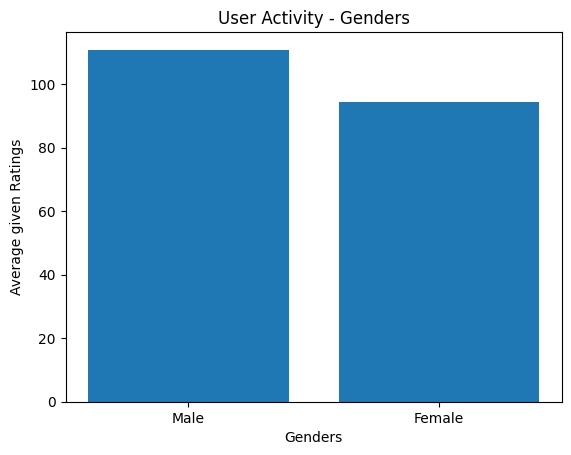

In [50]:
# Gender Activity 
gender_activity = [df[df["gender"]=='M']['Activity'].mean(), df[df["gender"]=='F']['Activity'].mean()]
plt.bar(['Male', "Female"], gender_activity)
plt.xlabel("Genders")
plt.ylabel("Average given Ratings")
plt.title("User Activity - Genders")
plt.show() 


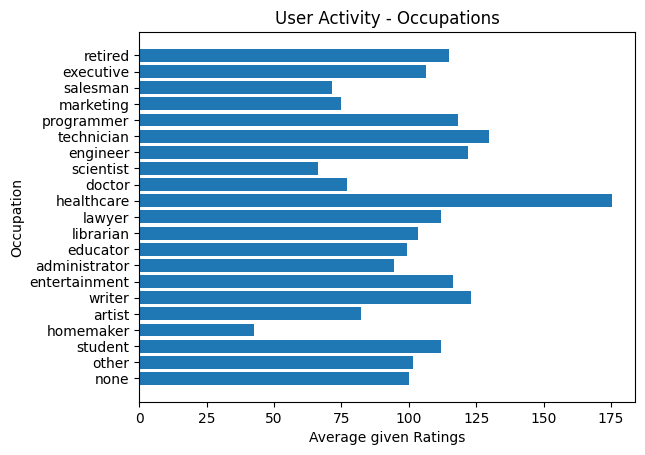

In [51]:
# Occupation Activity
occupation_activity = []
for occupation in occupation_list.keys():
    occupation_activity.append(df[df["occupation"]==occupation]['Activity'].mean())
plt.barh(list(occupation_list.keys()), occupation_activity)
plt.ylabel("Occupation")
plt.xlabel("Average given Ratings")
plt.title("User Activity - Occupations")
plt.show() 

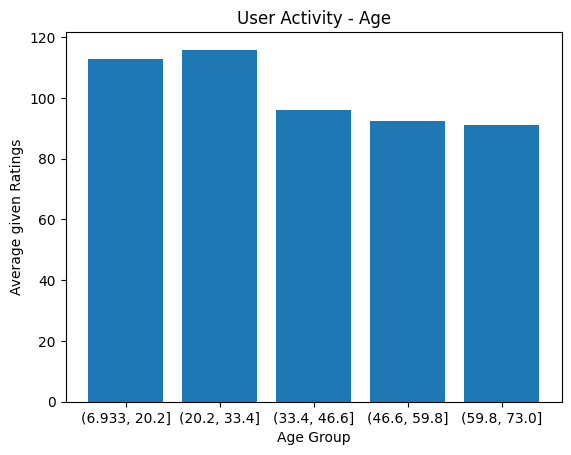

In [52]:
# Age Activity
age_activity = []
age_labels = [str(x) for x in age_counts.index]
for x in age_counts.index:
    age_activity.append(df[df.age.between(x.left, x.right)]['Activity'].mean())
plt.bar(age_labels, age_activity)
plt.xlabel("Age Group")
plt.ylabel("Average given Ratings")
plt.title("User Activity - Age")
plt.show() 

Males are slightly more active then Femals. The age has little impact on the user acitity. Younger people rate more movies. The biggest impact on the user activity has the occupation. 

### Data Preprocessing

Normalize age, gender and occupation to values between 0 and 1. This makes it easier to train.

In [53]:
# Gender: Convert 'M' and 'F' to 0 and 1
user_data['gender'] = np.where(np.matrix(user_data['gender']) == 'M', 0, 1)[0]

# Occupation
occupation_list = {"none": 0,  "other": 1, "student": 2, "homemaker": 3, "artist": 4, "writer": 5, "entertainment": 6, "administrator": 7, "educator": 8, "librarian": 9,
                   "lawyer": 10, "healthcare": 11, "doctor": 12, "scientist": 13, "engineer": 14, "technician": 15, "programmer": 16, "marketing": 17, "salesman": 18, 
                   "executive": 19, "retired": 20
                }
user_data['occupation'] = user_data['occupation'].map(occupation_list)
user_data['occupation'] = user_data["occupation"].apply(lambda x: x / 20)


min_age = min(user_data["age"])
max_age = max(user_data["age"])
user_data['age'] = user_data["age"].apply(lambda x: (x - min_age) / (max_age - min_age))

### Data Split

The data split is nothing special. The data is in random order so it can get split in 80:20 for training and validation data.

In [54]:
train_indices = int(0.8 * user_data.shape[0])

UA_x_train = user_data.to_numpy(dtype=np.float64)
UA_y_train = given_ratings.to_numpy(dtype=np.float64)/max_given_ratings

UA_x_train, UA_x_val, UA_y_train, UA_y_val = (
    UA_x_train[:train_indices],
    UA_x_train[train_indices:],
    UA_y_train[:train_indices],
    UA_y_train[train_indices:],
)

### Define & Train Model 

Code as start for this network: https://github.com/schutera/DeepDive

In [55]:
UA_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(16),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(8),
  tf.keras.layers.Dense(1)
])

In [56]:
loss_fn = tf.keras.losses.MeanSquaredError()
UA_model.compile(
              optimizer=keras.optimizers.Adam(),
              loss=loss_fn,
            )

In [57]:
UA_history = UA_model.fit(
        UA_x_train,
        UA_y_train,
        epochs=5,
        batch_size=4,
        validation_data=(UA_x_val, UA_y_val),
    )

Epoch 1/5
189/189 [==============================] - 1s 2ms/step - loss: 0.0281 - val_loss: 0.0143
Epoch 2/5
189/189 [==============================] - 0s 2ms/step - loss: 0.0221 - val_loss: 0.0150
Epoch 3/5
189/189 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0139
Epoch 4/5
189/189 [==============================] - 0s 2ms/step - loss: 0.0209 - val_loss: 0.0150
Epoch 5/5
189/189 [==============================] - 0s 2ms/step - loss: 0.0210 - val_loss: 0.0206


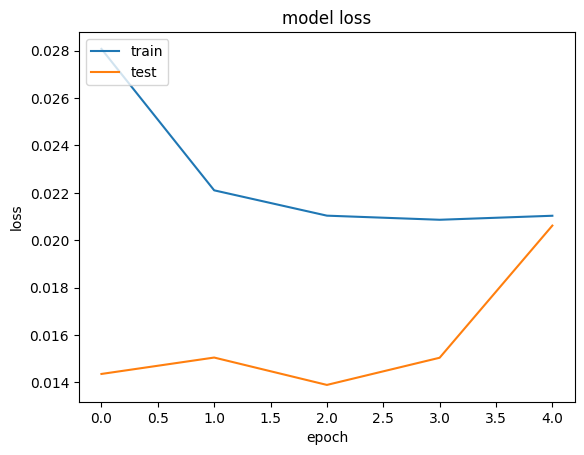

In [58]:
plt.plot(UA_history.history["loss"])
plt.plot(UA_history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

### Evaluation and Analysis

In [59]:
def get_user_activity_prediction(age: int, gender: int, occupation: str):
    age = (age-min_age)/(max_age-min_age)
    gender = np.clip(gender, 0, 1)
    occupation = occupation_list[occupation]
    occupation = np.clip(occupation/20, 0, 1)
    prediction = UA_model.predict(x=[[age, gender, occupation]]).item(0)
    prediction_absolute = int(prediction * max_given_ratings)
    prediction_relative = prediction *max_given_ratings / mean_given_ratings
    return prediction_absolute, prediction_relative

def print_predicted_user_activity(age: int, gender: int, occupation: str):
    print("----"*8)
    prediction_absolute, prediction_relative = get_user_activity_prediction(age, gender, occupation)
    if gender == 0:
        gender = 'Male'
    else: gender = 'Female'
    print("User: {} Years, {}, {}".format(age, gender, occupation))
    print("Predicted User Activity compared to Mean: {}".format(prediction_relative))
    print("Predicted given ratings: {}".format(prediction_absolute))

So now I want to try out same 'users':

User 1:
24 Years, Male, Student
-> I would predict a high User Activity.

User 2:
24 Years, Female, Student
-> My Prediciton: Less then User 1 because of Gender

User 3:
24 Years, Male, Artist
-> My Prediciton: Less then User 1 because of Occupation

User 4:
55 Years, Female, Student
-> My Prediciton: Less then User 2 because of Age

User 5:
30 Years, Male, Healthcare
-> My Prediciton: Highest Score (because of occupation)

User 6:
80 Years, Female, Homemaker
-> My Predicion: Lowest score



In [60]:
print_predicted_user_activity(24, 0, "student")
print_predicted_user_activity(24, 1, "student")
print_predicted_user_activity(24, 1, "artist")
print_predicted_user_activity(55, 1, "student")
print_predicted_user_activity(30, 0, "healthcare")
print_predicted_user_activity(80, 1, "homemaker")

--------------------------------
1/1 [==============================] - 0s 79ms/step
User: 24 Years, Male, student
Predicted User Activity compared to Mean: 1.3707437725271283
Predicted given ratings: 145
--------------------------------
1/1 [==============================] - 0s 39ms/step
User: 24 Years, Female, student
Predicted User Activity compared to Mean: 1.5594672113634644
Predicted given ratings: 165
--------------------------------
1/1 [==============================] - 0s 41ms/step
User: 24 Years, Female, artist
Predicted User Activity compared to Mean: 1.600292280628532
Predicted given ratings: 169
--------------------------------
1/1 [==============================] - 0s 36ms/step
User: 55 Years, Female, student
Predicted User Activity compared to Mean: 1.310891928127855
Predicted given ratings: 139
--------------------------------
1/1 [==============================] - 0s 37ms/step
User: 30 Years, Male, healthcare
Predicted User Activity compared to Mean: 1.422137005571126

As predicted User 6 has the lowest score. The first 3 Users have a greater User Acitivtiy then the average.

The other predicted outcomes did not arrive as expected.

## END :)